<a href="https://colab.research.google.com/github/ila/TUM/blob/master/Query%20Optimization/ComplimentSubgraph_enumeration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DPccp implementation
created by Zhenya Sharapov, edited by Ilaria Battiston


In [ ]:
import networkx as nx
import numpy as np
import pandas as pd

from networkx.algorithms.traversal import breadth_first_search
from matplotlib import pyplot as plt

<h3>Functions needed for the algorithm</h3>

In [ ]:
def create_graph(vertices, edges):
  """ Creates a networkx graph to represent the problem 
      @param vertices - a list of names of nodes
      @edges - a list of tuples (vertex_1, vertex_2)
      @returns a networkx.Graph g """

  g = nx.Graph()
  for vertex in vertices:
    g.add_node(vertex)
  
  for edge in edges:
    g.add_edge(*edge)

  nx.draw(g, with_labels=True)

  return g

def set_bfs_order(vertices, orders):
  """ saves the orders of the vertices, defined by users 
      @param vertices - a list of vertices to order
      @param orders - a list of orders, assigned to the corresponding elements of vertices """

  labeled_vertices = pd.DataFrame({'name': vertices, 'order': orders })
  labeled_vertices = labeled_vertices.set_index('name')
  return labeled_vertices


def get_pairs(g, labels):
  """ the main function which creates the table of connected subgraphs and
      corresponding compliments
      @param g - a networkx.Graph 
      @param labels - a pd.DataFrame storing the orders of the vertices """
      
  csgs = []

  cmp_csg = pd.DataFrame(columns=['csg', 'cmp'])

  labels_asc = labels.sort_values(by=['order'], ascending=True)
  labels_desc = labels.sort_values(by=['order'], ascending=False)

  nodes = list(g.nodes)
  adjacency = pd.DataFrame(nx.adjacency_matrix(g).todense(), index=nodes, columns=nodes)

  def get_B(nodeset):
    """ a function to return the nodes, that have order of less or equal to
        the minimal order of the entry of the nodeset
        @param nodeset - a set to determine the set of elements ltq to the minimal of it """

    if type(nodeset) != set:
      nodeset = set([nodeset])

    minimal = min(labels[labels.index.isin(nodeset)].order)

    return set(labels[labels.order <= minimal].index)

  def get_N(nodeset):
    """ returns a set of nodes, connected directly to the nodeset
        @param nodeset """

    if type(nodeset) != set:
      nodeset = set([nodeset])

    N = set()
    for node in nodeset:
      row = adjacency.loc[node].to_frame()
      to_add = set(row[row[node] == 1].index)
      N.update(to_add)

    return N

  def subset_generator(S):
    """ generator, that generates the subsets of the S
        @param S - a set to find the subsets of it
        @yields the subsets of S in the ascending order of the BFS ordering"""
        
    n = len(nodes)

    for i in range(1, 2 ** n):
      binary = "{0:b}".format(i)
      binary = list(('0' * (n - len(binary)) + binary))
      binary.reverse()
      indices = np.where(np.array(binary, dtype=np.int8))[0]
      S_sub = set(labels_asc.iloc[indices].index)
      if S_sub.issubset(S) and len(S_sub) > 0:
        yield S_sub

  def enumerate_components_rec(S, X, write_to=csgs):
    """ recursively propagates over the graph to find the connected subgraphs 
        @param S - a set, whose subsets are searched for
        @param X - a set of elements to be forbidden
        @param write_to - defines a data structure to store the intermediate results to"""

    rookies = []
    N = get_N(S)
    N = N.difference(X)

    for S_subset in subset_generator(N):
      rookie = S.union(S_subset)
      rookies.append(rookie)

    write_to.extend(rookies)

    for rookie in rookies:
      enumerate_components_rec(rookie, X.union(N), write_to)

  def enumerate_components():
    """ an initial function, which emits single vertices and starts propagation of
        recursion """

    for v in labels_desc.index:
      vs = set([v])
      csgs.append(vs)
      B_v = get_B(v)
      enumerate_components_rec(vs, B_v)

  def enumerate_compliments(S, table=cmp_csg):
    """ findas a set of compliments to the input connected subgraph
        @param S - a subset to find compliment to
        @param table - a DataFrame object to write results into 
        @returns an updated table """

    X = get_B(S).union(S)
    N = get_N(S).difference(X)
    for v in labels_desc.index:
      if v in N:
        cmps = []
        vs = set([v])
        cmps.append(vs)
        enumerate_components_rec(vs, X.union(N.intersection(get_B(v))), write_to=cmps)
        for component in cmps:
          table = table.append({'csg': S, 'cmp': component}, ignore_index=True)
    return table


  enumerate_components()
  for S in csgs:
    cmp_csg = enumerate_compliments(S, cmp_csg)

  return cmp_csg.set_index("csg")


<h3>Unit tests (from Bernhard Radke)</h3>

1) From the document https://www.moodle.tum.de/pluginfile.php/2672107/mod_resource/content/2/dpccp.pdf

2) From the additional exercise sheet



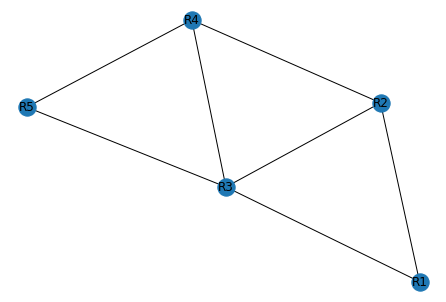

In [ ]:
vertices = ['R1', 'R2', 'R3', 'R4', 'R5']
edges = [('R1', 'R2'), ('R1', 'R3'), ('R2', 'R3'), ('R2', 'R4'), ('R3', 'R4'), ('R3', 'R5'), ('R4', 'R5')]
orders = [1, 2, 3, 4, 5]

g = create_graph(vertices, edges)
labels = set_bfs_order(vertices, orders)

In [ ]:
get_pairs(g, labels)

,cmp
csg,
{R4},{R5}
{R3},{R5}
{R3},{R4}
{R3},"{R4, R5}"
"{R3, R4}",{R5}
"{R3, R5}",{R4}
{R2},{R4}
{R2},"{R4, R5}"
{R2},{R3}


###Actual algorithm with variable input data

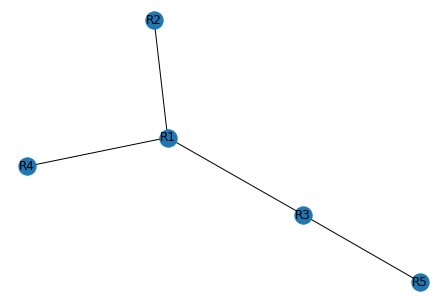

In [ ]:
# INPUT DATA TO BE INSERTED HERE

vertices = ['R1', 'R2', 'R3', 'R4', 'R5']
edges = [('R1', 'R2'), ('R1', 'R4'), ('R1', 'R3'), ('R3', 'R5')]
orders = [1, 2, 3, 4, 5]

g = create_graph(vertices, edges)
labels = set_bfs_order(vertices, orders)

In [ ]:
get_pairs(g, labels)

,cmp
csg,
{R3},{R5}
{R1},{R4}
{R1},{R3}
{R1},"{R3, R5}"
{R1},{R2}
"{R1, R2}",{R4}
"{R1, R2}",{R3}
"{R1, R2}","{R3, R5}"
"{R3, R1}",{R5}
